In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import h5py

from os import path
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.image import ResizeMethod

AUTOTUNE = tf.data.AUTOTUNE
TRAIN_DIR = "/content/drive/MyDrive/Data/"
SCALE_FACTOR = 2

In [2]:
def random_rotate(imgs):
    """Rotates Images by 90 degrees."""

    _rotated= []
    for img in imgs:
      # Outputs random values from uniform distribution in between 0 to 4
      rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
      # Here rn signifies number of times the image(s) are rotated by 90 degrees
      _rotated.append(tf.image.rot90(img, rn))

    return _rotated

def flip_left_right(imgs):
    """Flips Images to left and right."""
    _flipped= []
    for img in imgs:
      # Here rn signifies number of times the image(s) are rotated by 90 degrees
      _flipped.append(tf.image.flip_left_right(img))

    return _flipped

def resize_bicubic(images, size):
  """Resizes images to the give size
  """
  return tf.image.resize(
    images,
    size,
    method=ResizeMethod.BICUBIC,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
    )

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image


In [17]:
def prepare_data (split=(0.7, 0.2, 0.1)):
    
    set14_path = os.path.join("./Data","Set14/Set14")
    set5_path = os.path.join("./Data","Set5/Set5")
    all_images = [np.array(Image.open(path.join(set14_path, name))) for name in os.listdir(set14_path)]
    all_images += [np.array(Image.open(path.join(set5_path, name))) for name in os.listdir(set5_path)]

    # shuffle, flip, rotate, bicubic down /up (low_res, high_res)
    all_images += random_rotate(all_images)
    all_images += flip_left_right(all_images)
    
    train_data = []
    _x = []
    _Y = []
    # train_data
    for img in all_images:
        img_gt = resize_bicubic(img, (128, 128))

        # downscale image by factor {SCALE_FACTOR}
        lr_img = resize_bicubic(img_gt, [img_gt.shape[0]// SCALE_FACTOR, img_gt.shape[1] // SCALE_FACTOR])
        
        # upscale the downscaled image back to original shape
        lr_img = resize_bicubic(lr_img, [lr_img.shape[0] * SCALE_FACTOR, lr_img.shape[1] * SCALE_FACTOR])
        
        _x.append(lr_img)
        _Y.append(img_gt)
            
    # split into test / train
    # train, test = train_test_split(train_data, random_state=12, train_size= 0.7)
    print(f"{len(_x)} {len(_Y)}")
    return _x, _Y

prepare_data()

76 76


([<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
  array([[[ 96.64822 ,  96.64822 ,  96.64822 ],
          [110.39609 , 110.39609 , 110.39609 ],
          [139.51236 , 139.51236 , 139.51236 ],
          ...,
          [ 84.34014 ,  84.34014 ,  84.34014 ],
          [ 94.77848 ,  94.77848 ,  94.77848 ],
          [ 99.70311 ,  99.70311 ,  99.70311 ]],
  
         [[101.59815 , 101.59815 , 101.59815 ],
          [117.45303 , 117.45303 , 117.45303 ],
          [151.0373  , 151.0373  , 151.0373  ],
          ...,
          [ 83.18028 ,  83.18028 ,  83.18028 ],
          [ 90.75357 ,  90.75357 ,  90.75357 ],
          [ 94.326225,  94.326225,  94.326225]],
  
         [[112.08951 , 112.08951 , 112.08951 ],
          [132.40952 , 132.40952 , 132.40952 ],
          [175.46219 , 175.46219 , 175.46219 ],
          ...,
          [ 80.7174  ,  80.7174  ,  80.7174  ],
          [ 82.22252 ,  82.22252 ,  82.22252 ],
          [ 82.93169 ,  82.93169 ,  82.93169 ]],
  
         ...,
  
     

In [37]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    hight resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

def resize_bicubic(images, size):
  """Resizes images to the give size
  """
  return tf.image.resize(
    images,
    size,
    method=ResizeMethod.BICUBIC,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
)


In [4]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


In [5]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            for i in range(len(x)):
                y_pred = self(x[i], training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compiled_loss(y[i], y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


76 76


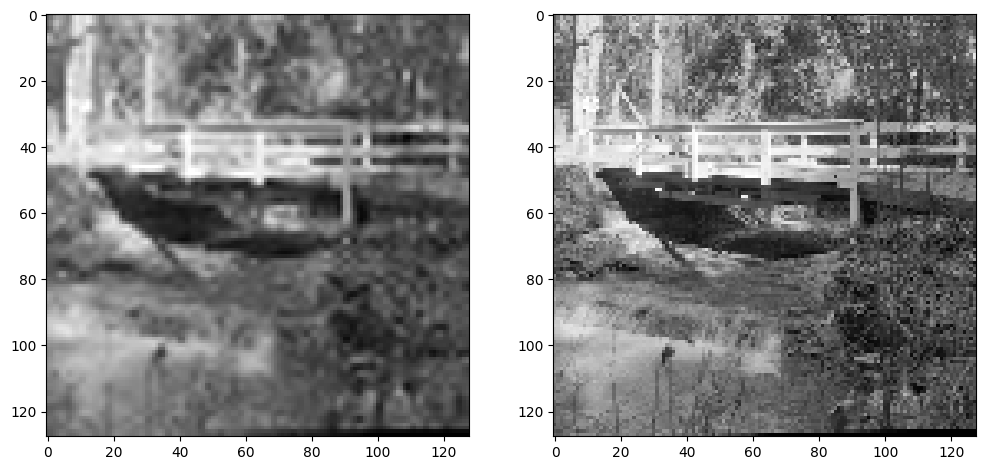

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[ 96.64822 ,  96.64822 ,  96.64822 ],
         [110.39609 , 110.39609 , 110.39609 ],
         [139.51236 , 139.51236 , 139.51236 ],
         ...,
         [ 84.34014 ,  84.34014 ,  84.34014 ],
         [ 94.77848 ,  94.77848 ,  94.77848 ],
         [ 99.70311 ,  99.70311 ,  99.70311 ]],
 
        [[101.59815 , 101.59815 , 101.59815 ],
         [117.45303 , 117.45303 , 117.45303 ],
         [151.0373  , 151.0373  , 151.0373  ],
         ...,
         [ 83.18028 ,  83.18028 ,  83.18028 ],
         [ 90.75357 ,  90.75357 ,  90.75357 ],
         [ 94.326225,  94.326225,  94.326225]],
 
        [[112.08951 , 112.08951 , 112.08951 ],
         [132.40952 , 132.40952 , 132.40952 ],
         [175.46219 , 175.46219 , 175.46219 ],
         ...,
         [ 80.7174  ,  80.7174  ,  80.7174  ],
         [ 82.22252 ,  82.22252 ,  82.22252 ],
         [ 82.93169 ,  82.93169 ,  82.93169 ]],
 
        ...,
 
        [[ 93.44588 ,  93.44588 

In [24]:
_x, _Y = prepare_data()

fig= plt.figure(figsize=(12,12))

plt.subplot(1,2, 1)
plt.imshow(_x[0]/255)
plt.subplot(1,2, 2)
plt.imshow(_Y[0]/255)
plt.show()
_x

In [23]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(_x, _Y, epochs=100, steps_per_epoch=200, validation_split=0.2)


TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

In [7]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)


NameError: ignored